<a href="https://colab.research.google.com/github/saeloman/APNEE_SOMMEIL/blob/main/Tested_Version_LLM_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Practical

<img src="https://www.marktechpost.com/wp-content/uploads/2023/05/Blog-Banner-3.jpg" width="60%" />


© .

**Author: ALIAMINI **

**Introduction:**

Bienvenue dans votre Practical sur les LLMs —votre porte d'entrée vers le monde fascinant des Modèles de Langage de Grande Taille !

Dans ce tutoriel, vous aurez l'occasion de vous exercer à entraîner votre propre Modèle de Langage (LLM) ! Préparez-vous à explorer comment ces systèmes d'IA impressionnants créent des textes aussi réalistes et captivants. Partons ensemble pour ce voyage passionnant et déverrouillons les secrets des LLMs ! 🚀📚

**Prérequis :**

* Bases en Python.
* Connaissances introductives en Machine Learning.
* Connaissances introductives en NLP.

NB: Ce notebook utilise le framework JAX.

**Plan :**

>[Installations & Importations](#scrollTo=6EqhIg1odqg0)

>[Entraînement de votre LLM](#scrollTo=wmt3tp38G90A)

>>[1. Objectif d'entraînement Intermédiaire](#scrollTo=jGKuXIJJyyo8)

>>[2. Entraînement des modèles Avancés](#scrollTo=4CSfvGj__RGA)

>>[3. Inspecter le LLM entraîné Débutant](#scrollTo=pGv9c2AFmF4V)

>[Conclusion](#scrollTo=15296-QL3-y3)

**Avant de commencer :**

Pour ce TP, vous aurez besoin d'utiliser un GPU pour accélérer l'entraînement. Pour ce faire, allez dans le menu "Exécution" de Colab, sélectionnez "Modifier le type d'exécution", puis dans le menu popup, choisissez "T4 GPU" dans la boîte "Accélérateur matériel".


## Installations & Importations


In [ ]:
# Installer les bibliothèques nécessaires pour le deep learning, le NLP et la visualisation
!pip install transformers datasets  # Bibliothèques Transformers et datasets pour les tâches de NLP
!pip install seaborn umap-learn     # Seaborn pour la visualisation, UMAP pour la réduction dimensionnelle
!pip install livelossplot           # LiveLossPlot pour suivre les progrès de l'entraînement du modèle
!pip install -q transformers[torch] # Transformers avec le backend PyTorch
!pip install -q peft                # Bibliothèque de fine-tuning efficient en paramètres
!pip install accelerate -U          # Bibliothèque Accelerate pour les performances

# Installer des utilitaires pour le débogage et le formatage de la sortie console
!pip install -q ipdb                # Débogueur interactif Python
!pip install -q colorama            # Sortie de texte colorée dans le terminal

# Importer des utilitaires système et mathématiques
import os
import math
import urllib.request

# Vérifier les accélérateurs connectés (GPU ou TPU) et configurer en conséquence
if os.environ.get("COLAB_GPU") and int(os.environ["COLAB_GPU"]) > 0:
    print("Un GPU est connecté.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("Un TPU est connecté.")
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
else:
    print("Seul le processeur (CPU) est connecté.")

# Éviter que l'allocation de mémoire GPU soit effectuée par JAX
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

# Importer les bibliothèques pour le deep learning basé sur JAX
import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import optax

# Importer les bibliothèques liées au NLP et aux modèles
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets
import peft

# Importer les bibliothèques pour le traitement d'images et la visualisation
from PIL import Image
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Importer des utilitaires supplémentaires pour travailler avec le texte et les modèles
import torch
import torchvision
import itertools
import random
import copy

# Télécharger une image d'exemple à utiliser dans le notebook
urllib.request.urlretrieve(
    "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
    "cat.png",
)

# Importer les bibliothèques pour le prétraitement NLP et le travail avec des modèles pré-entraînés
import gensim
from nltk.data import find
import nltk
nltk.download("word2vec_sample")

# Importer les outils Hugging Face et les widgets IPython
import huggingface_hub
import ipywidgets as widgets
from IPython.display import display
import colorama

# Configurer Matplotlib pour générer des graphiques au format SVG pour une meilleure qualité
%config InlineBackend.figure_format = 'svg'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00
   ━

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


## Entraînement de votre LLM


### 1. Objectif d'entraînement <font color='green'>Intermédiaire</font>

Une phrase n'est rien d'autre qu'une chaîne de mots. Un LLM vise à prédire le mot suivant en tenant compte du contexte actuel, c'est-à-dire des mots qui l'ont précédé.

Voici l'idée de base :

Pour calculer la probabilité d'une phrase complète "mot1, mot2, ..., dernier mot" apparaissant dans un contexte donné $c$, la procédure consiste à décomposer la phrase en mots individuels et à considérer la probabilité de chaque mot étant donné les mots qui le précèdent. Ces probabilités individuelles sont ensuite multipliées ensemble :

$$\text{Probabilité de la phrase} = \text{Probabilité de mot1} \times \text{Probabilité de mot2} \times \ldots \times \text{Probabilité du dernier mot}$$

Cette méthode est semblable à la construction d'une narration pièce par pièce en fonction de l'histoire précédente.

Mathématiquement, cela s'exprime comme la vraisemblance (probabilité) d'une séquence de mots $y_1, y_2, ..., y_n$ dans un contexte donné $c$, ce qui est réalisé en multipliant les probabilités de chaque mot $y_t$ calculées étant donné les prédécesseurs ($y_{<t}$) et le contexte $c$ :

$$
P\left(y_{1}, y_{2}, \ldots, y_{n}, \mid c\right)=\prod_{t=1}^{n} P\left(y_{t} \mid y_{<t}, c\right)
$$

Ici $y_{<t}$ représente la séquence $y_1, y_2, ..., y_{t-1}$, tandis que $c$ représente le contexte.

Cela est analogue à résoudre un puzzle où la pièce suivante est placée prévisiblement en fonction de ce qui est déjà en place.

Rappelez-vous que lors de l'entraînement d'un transformateur, nous ne travaillons pas avec des mots, mais avec des tokens. Pendant le processus d'entraînement, les paramètres du modèle sont affinés en calculant la perte de l'entropie croisée entre le token prédit et le token correct, puis en effectuant une rétropropagation. La perte pour l'étape temporelle "t" est calculée comme suit :

$$ \text{Perte}_t = - \sum_{w \in V} y_t\log (\hat{y}_t) $$

Ici $y_t$ est le token réel à l'étape temporelle $t$, et $\hat{y}_t$ est le token prédit par le modèle à la même étape temporelle. La perte pour l'ensemble de la phrase est ensuite calculée comme suit :

$$ \text{Perte de la phrase} = \frac{1}{n} \sum^{n}_{t=1} \text{Perte}_t $$

où $n$ est la longueur de la séquence.

Ce processus itératif affine finalement les capacités prédictives du modèle au fil du temps.

**Tâche de code** : Implémentez la fonction de perte d'entropie croisée ci-dessous.


In [ ]:
def sequence_loss_fn(logits, targets):
  '''
  Calculer la perte d'entropie croisée entre l'ID de token prédit et l'ID réel.

  Args:
    logits: Un tableau de forme [batch_size, sequence_length, vocab_size]
    targets: Les IDs de token réels que nous essayons de prédire, forme [batch_size, sequence_length]

  Returns:
    loss: Une valeur scalaire représentant la perte moyenne du lot
  '''

  target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)
  assert logits.shape == target_labels.shape

  per_token_loss = -jnp.sum(target_labels* jnp.log_softmax(logits),axis=-1)

  mask = jnp.greater(targets, 0)

  masked_loos = jnp.sum(per_token_loss*mask)/jnp.sum(mask)

  loss = ... # FINIR MOI

  return loss


In [ ]:
# @title Exécutez-moi pour tester votre code
VOCAB_SIZE = 25670
targets = jnp.array([[0, 2, 0]])
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [1, 3, VOCAB_SIZE])
loss = sequence_loss_fn(X, targets)
real_loss = jnp.array(10.966118)
assert jnp.allclose(real_loss, loss), "La valeur retournée n'est pas correcte"
print("Il semble correct. Consultez la réponse ci-dessous pour comparer les méthodes.")

Il semble correct. Consultez la réponse ci-dessous pour comparer les méthodes.


In [ ]:
# @title Réponse à la tâche de code (Essayez de ne pas regarder avant d'avoir bien essayé !)
def sequence_loss_fn(logits, targets):
    """Calculer la perte de séquence entre les logits prédits et les étiquettes cibles."""

    # Convertir les indices cibles en vecteurs encodés en one-hot.
    # Chaque étiquette cible est convertie en un vecteur one-hot de taille VOCAB_SIZE.
    target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)

    # Assurer que la forme des logits correspond à la forme des cibles encodées en one-hot.
    # C'est important car nous devons calculer la perte sur les dimensions correspondantes.
    assert logits.shape == target_labels.shape

    # Créer un masque qui ignore les jetons de padding dans le calcul de la perte.
    # Le masque est True (1) lorsque la valeur cible est supérieure à 0 et False (0) sinon.
    mask = jnp.greater(targets, 0)

    # Calculer la perte d'entropie croisée pour chaque jeton.
    # L'entropie croisée est calculée comme le logarithme négatif de la probabilité de la classe correcte.
    # jax.nn.log_softmax(logits) nous donne les probabilités logarithmiques pour chaque classe.
    # Nous multiplions par les target_labels pour sélectionner la probabilité logarithmique de la classe correcte.
    loss = -jnp.sum(target_labels * jax.nn.log_softmax(logits), axis=-1)

    # Appliquer le masque à la perte pour ignorer les positions de padding et additionner les pertes.
    # Nous normalisons ensuite la perte totale par le nombre de jetons non-padding.
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss


### 2. Entraînement des modèles <font color='blue'>Avancé</font>


Dans la section suivante, nous définissons tous les processus nécessaires pour entraîner le modèle en utilisant l'objectif décrit ci-dessus. Une grande partie de cela concerne maintenant le travail requis pour effectuer l'entraînement avec FLAX.

Ci-dessous, nous rassemblons le jeu de données sur lequel nous allons entraîner, qui est le jeu de données de Shakespeare de Karpathy. Il n'est pas si important de comprendre ce code, donc soit exécutez simplement la cellule pour charger les données, soit consultez le code si vous souhaitez le comprendre.


In [ ]:
# @title Créer le jeu de données Shakespeare et l'itérateur (optionnel, mais exécutez la cellule)

# Astuce pour éviter les erreurs lors du téléchargement de tinyshakespeare.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

class WordBasedAsciiDatasetForLLM:
    """Jeu de données en mémoire d'un fichier ASCII unique pour un modèle de type langage."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Charger un fichier ASCII unique en mémoire."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokeniser en séparant le texte en mots
        words = corpus.split()
        self.vocab_size = len(set(words))  # Nombre de mots uniques

        # Créer un mapping de mots vers des IDs uniques
        self.word_to_id = {word: i for i, word in enumerate(set(words))}

        # Stocker le mapping inverse des IDs vers les mots
        self.id_to_word = {i: word for word, i in self.word_to_id.items()}

        # Convertir les mots du corpus en leurs IDs correspondants
        corpus = np.array([self.word_to_id[word] for word in words]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Seulement {num_batches} lots ; envisagez une séquence plus courte "
                "ou un lot plus petit."
            )

        self._ds = WordBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Générer le prochain mini-lot."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Créer les paires observation/cible pour la modélisation du langage.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_words(self, ids):
        """Convertir une séquence d'IDs de mots en mots."""
        return [self.id_to_word[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Répéter et mélanger infiniment les données de l'itérable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclus.
            result, buf[idx] = buf[idx], item
            yield result


--2024-11-23 12:40:26--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-11-23 12:40:27 (28.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



Lets now look how our data is structured for training

In [ ]:
# Échantillonner et examiner les données
batch_size = 2
seq_length = 32
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)

batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Entrée", "-" * 11)
    print("TEXTE :", ' '.join(train_dataset.ids_to_words(obs)))
    print("ASCII :", obs)
    print("-" * 10, "Cible", "-" * 10)
    print("TEXTE :", ' '.join(train_dataset.ids_to_words(target)))
    print("ASCII :", target)

print(f"\n Taille totale du vocabulaire : {train_dataset.vocab_size}")

VOCAB_SIZE = train_dataset.vocab_size


---------- Entrée -----------
TEXTE : yourselves? First Citizen: We cannot, sir, we are undone already. MENENIUS: I tell you, friends, most charitable care Have the patricians of you. For your wants, Your suffering in this dearth, you
ASCII : [ 7165 21225  6386 12051 23400 20648 13970 24075 10855 21358  6834 18610
 18866 10949 18923  5916  6643 23574  8974 18551 11030 11271 11796 16902
 14743 10072 18124 14937  2720 24085 20056 24497]
---------- Cible ----------
TEXTE : First Citizen: We cannot, sir, we are undone already. MENENIUS: I tell you, friends, most charitable care Have the patricians of you. For your wants, Your suffering in this dearth, you may
ASCII : [21225  6386 12051 23400 20648 13970 24075 10855 21358  6834 18610 18866
 10949 18923  5916  6643 23574  8974 18551 11030 11271 11796 16902 14743
 10072 18124 14937  2720 24085 20056 24497  1467]
---------- Entrée -----------
TEXTE : talking on't; let it be done: away, away! Second Citizen: One word, good citizens. First Citiz

Ensuite, entraînons notre LLM et voyons comment il se comporte pour produire du texte shakespearien. Tout d'abord, nous allons définir ce qui se passe à chaque étape d'entraînement.


In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(3, 4))
def train_step(params, optimizer_state, batch, apply_fn, update_fn):
    """
    Effectuer une étape d'entraînement.

    Args:
        params: Les paramètres actuels du modèle.
        optimizer_state: L'état actuel de l'optimiseur.
        batch: Un dictionnaire contenant les données d'entrée et les étiquettes cibles pour le batch.
        apply_fn: La fonction utilisée pour appliquer le modèle aux entrées.
        update_fn: La fonction utilisée pour mettre à jour les paramètres du modèle en fonction des gradients.

    Returns:
        Paramètres mis à jour, état de l'optimiseur mis à jour, et la perte calculée pour le batch.
    """

    def loss_fn(params):
        # Obtenez la longueur de la séquence (T) à partir des données d'entrée.
        T = batch['input'].shape[1]

        # Appliquez le modèle aux données d'entrée, en utilisant un masque triangulaire inférieur pour imposer la causalité.
        # jnp.tril(np.ones((T, T))) crée une matrice triangulaire inférieure de uns.
        logits = apply_fn(params, batch['input'], jnp.tril(np.ones((T, T))))

        # Calculez la perte entre les logits prédits et les étiquettes cibles.
        loss = sequence_loss_fn(logits, batch['target'])

        return loss

    # Calculez la perte et ses gradients par rapport aux paramètres.
    loss, gradients = jax.value_and_grad(loss_fn)(params)

    # Mettez à jour l'état de l'optimiseur et calculez les mises à jour des paramètres en fonction des gradients.
    updates, optimizer_state = update_fn(gradients, optimizer_state)

    # Appliquez les mises à jour aux paramètres.
    params = optax.apply_updates(params, updates)

    # Retournez les paramètres mis à jour, l'état de l'optimiseur, et la perte pour le batch.
    return params, optimizer_state, loss


Nous allons maintenant initialiser notre optimiseur et notre modèle. N'hésitez pas à expérimenter avec les hyperparamètres pendant la pratique.


In [ ]:
def return_frequency_pe_matrix(longueur_sequence_tokens, taille_embedding_tokens):

    assert taille_embedding_tokens % 2 == 0, "la taille de l'embedding des tokens doit être divisible par deux"

    P = jnp.zeros((longueur_sequence_tokens, taille_embedding_tokens))
    positions = jnp.arange(0, longueur_sequence_tokens)[:, jnp.newaxis]

    i = jnp.arange(0, taille_embedding_tokens, 2)
    pas_frequence = jnp.exp(i * (-math.log(10000.0) / taille_embedding_tokens))
    frequences = positions * pas_frequence

    P = P.at[:, 0::2].set(jnp.sin(frequences))
    P = P.at[:, 1::2].set(jnp.cos(frequences))

    return P

In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Attention à produit scalaire échelonné avec un masque causal
    (se concentrant uniquement sur les positions précédentes)
    """
    d_k = key.shape[-1]
    T_k = key.shape[-2]
    T_q = query.shape[-2]

    # obtenir les logits échelonnés en utilisant le produit scalaire comme précédemment
    logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
    scaled_logits = logits / jnp.sqrt(d_k)

    # ajouter un masque optionnel où les valeurs le long du masque sont définies à -inf
    if mask is not None:
        scaled_logits = jnp.where(mask[:T_q, :T_k], scaled_logits, -jnp.inf)

    # calculer les poids d'attention via softmax
    attention_weights = jax.nn.softmax(scaled_logits, axis=-1)

    # faire la somme avec les valeurs pour obtenir la sortie
    output = jnp.matmul(attention_weights, value)

    return output, attention_weights

In [ ]:
class SequenceToQKV(nn.Module):
  taille_sortie: int

  @nn.compact
  def __call__(self, X):

    # définir la méthode d'initialisation des poids
    initialisateur = nn.initializers.variance_scaling(scale=0.5, mode="fan_in", distribution="truncated_normal")

    # initialiser trois couches linéaires pour faire les transformations QKV.
    # note : cela pourrait aussi être une seule couche, comment pensez-vous que vous le feriez ?
    couche_q = nn.Dense(self.taille_sortie, kernel_init=initialisateur)
    couche_k = nn.Dense(self.taille_sortie, kernel_init=initialisateur)
    couche_v = nn.Dense(self.taille_sortie, kernel_init=initialisateur)

    # transformer et retourner les matrices
    Q = couche_q(X)
    K = couche_k(X)
    V = couche_v(X)

    return Q, K, V


In [ ]:
class MultiHeadAttention(nn.Module):
    num_heads: int  # Nombre de têtes d'attention
    d_m: int  # Dimension des embeddings du modèle

    def setup(self):
        # Initialiser le module de transformation de la séquence en QKV (requête, clé, valeur)
        self.sequence_to_qkv = SequenceToQKV(self.d_m)

        # Définir l'initialiseur pour les poids de la couche linéaire de sortie
        initializer = nn.initializers.variance_scaling(
            scale=0.5, mode="fan_in", distribution="truncated_normal"
        )

        # Initialiser la couche de projection de sortie Wo (utilisée après l'attention)
        self.Wo = nn.Dense(self.d_m, kernel_init=initializer)

    def __call__(self, X=None, Q=None, K=None, V=None, mask=None, return_weights=False):
        # Si Q, K ou V ne sont pas fournis, utiliser l'entrée X pour les générer
        if None in [Q, K, V]:
            assert not X is None, "X doit être fourni si Q, K ou V ne sont pas fournis"

            # Générer les matrices Q, K et V à partir de l'entrée X
            Q, K, V = self.sequence_to_qkv(X)

        # Extraire la taille du lot (B), la longueur de la séquence (T) et la taille de l'embedding (d_m)
        B, T, d_m = K.shape

        # Calculer la taille de l'embedding de chaque tête d'attention (d_m / num_heads)
        head_size = d_m // self.num_heads

        # Reshaper Q, K, V pour avoir des dimensions séparées pour les têtes
        # B, T, d_m -> B, T, num_heads, head_size -> B, num_heads, T, head_size
        q_heads = Q.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)
        k_heads = K.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)
        v_heads = V.reshape(B, T, self.num_heads, head_size).swapaxes(1, 2)

        # Appliquer l'attention à produit scalaire échelonné à chaque tête
        attention, attention_weights = scaled_dot_product_attention(
            q_heads, k_heads, v_heads, mask
        )

        # Reshaper la sortie de l'attention à ses dimensions originales
        # (B, num_heads, T, head_size) -> (B, T, num_heads, head_size) -> (B, T, d_m)
        attention = attention.swapaxes(1, 2).reshape(B, T, d_m)

        # Appliquer la transformation linéaire de sortie Wo à la sortie de l'attention
        X_new = self.Wo(attention)

        # Si return_weights est True, retourner à la fois la sortie transformée et les poids d'attention
        if return_weights:
            return X_new, attention_weights
        else:
            # Sinon, retourner uniquement la sortie transformée
            return X_new


In [ ]:
class AddNorm(nn.Module):
    """Un bloc qui implémente l'opération 'Add and Norm' utilisée dans les transformers."""

    @nn.compact
    def __call__(self, x, processed_x):
      # Étape 1 : Ajouter l'entrée originale (x) à l'entrée traitée (processed_x).
      added = x + processed_x

      # Étape 2 : Appliquer une normalisation par couche au résultat de l'addition.
      # - LayerNorm aide à stabiliser et améliorer le processus d'entraînement en normalisant la sortie.
      # - reduction_axes=-1 indique que la normalisation est appliquée sur la dernière dimension (généralement la dimension de l'embedding).
      # - use_scale=True et use_bias=True permettent à la couche d'apprendre des paramètres d'échelle et de biais pour un ajustement plus précis.
      normalised = nn.LayerNorm(reduction_axes=-1, use_scale=True, use_bias=True)

      # Retourner le résultat normalisé.
      return normalised(added)

In [ ]:
class FeedForwardBlock(nn.Module):
    """Un MLP (Multi-Layer Perceptron) à 2 couches qui commence par élargir la taille de l'entrée, puis la réduit à nouveau."""

    # widening_factor contrôle l'expansion de la dimension de l'entrée dans la première couche.
    widening_factor: int = 4

    # init_scale contrôle le facteur d'échelle pour l'initialisation des poids.
    init_scale: float = 0.25

    @nn.compact
    def __call__(self, x):
      # Obtenir la taille de la dernière dimension de l'entrée (taille de l'embedding).
      d_m = x.shape[-1]

      # Calculer la taille de la première couche en multipliant la taille de l'embedding par le facteur d'élargissement.
      layer1_size = self.widening_factor * d_m

      # Initialiser les poids des deux couches en utilisant un initialiseur basé sur la variance.
      initializer = nn.initializers.variance_scaling(
          scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
      )

      # Définir la première couche dense, qui élargit la taille de l'entrée.
      layer1 = nn.Dense(layer1_size, kernel_init=initializer)

      # Définir la deuxième couche dense, qui réduit la taille pour revenir à la dimension d'origine.
      layer2 = nn.Dense(d_m, kernel_init=initializer)

      # Appliquer la première couche dense suivie d'une fonction d'activation GELU.
      x = jax.nn.gelu(layer1(x))

      # Appliquer la deuxième couche dense pour ramener les données à leur dimension d'origine.
      x = layer2(x)

      # Retourner la sortie finale.
      return x


In [ ]:
class DecoderBlock(nn.Module):
    """
    Bloc décodeur du Transformer.

    Args:
        num_heads: Le nombre de têtes d'attention dans le bloc Multi-Head
        Attention (MHA).
        d_m: La taille des embeddings des tokens.
        widening_factor: Le facteur par lequel la taille de la couche cachée
        est augmentée dans le MLP.
    """

    num_heads: int
    d_m: int
    widening_factor: int = 4

    def setup(self):
      # Initialiser le bloc Multi-Head Attention (MHA)
      self.mha = MultiHeadAttention(self.num_heads, self.d_m)

      # Initialiser les blocs AddNorm pour les connexions résiduelles
      # et la normalisation
      self.add_norm1 = AddNorm()  # Premier bloc AddNorm après MHA
      self.add_norm2 = AddNorm()  # Deuxième bloc AddNorm après le MLP

      # Initialiser le FeedForwardBlock (MLP) qui traite les données
      # après l'attention
      self.MLP = FeedForwardBlock(widening_factor=self.widening_factor)

    def __call__(self, X, mask=None, return_att_weight=True):
      """
      Passage en avant à travers le DecoderBlock.

      Args:
          X: Lot de tokens d'entrée envoyés dans le décodeur,
          forme [B, T_decoder, d_m]
          mask [optionnel, par défaut=None]: Masque pour contrôler les positions
          que l'attention est autorisée à considérer,
          forme [T_decoder, T_decoder].
          return_att_weight [optionnel, par défaut=True]: Si True,
          retourne les poids d'attention avec la sortie.

      Returns:
          Si return_att_weight est True, retourne un tuple (X,
          attention_weights_1).
          Sinon, retourne les représentations des tokens traités X.
      """
      # Appliquer l'attention multi-tête aux tokens d'entrée (X)
      # avec un masquage optionnel
      attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)

      # Appliquer le premier bloc AddNorm (ajoute l'entrée originale X
      # et normalise)
      X = self.add_norm1(X, attention)

      # Passer le résultat à travers le FeedForwardBlock (MLP)
      # pour traiter davantage les données
      projection = self.MLP(X)

      # Appliquer le deuxième bloc AddNorm (ajoute l'entrée de l'étape
      # précédente et normalise)
      X = self.add_norm2(X, projection)

      # Retourner la sortie finale X, et éventuellement les poids d'attention
      return (X, attention_weights_1) if return_att_weight else X

In [ ]:
class LLM(nn.Module):
    """
    Modèle Transformer composé de plusieurs couches de blocs décodeurs.

    Args:
        num_heads: Nombre de têtes d'attention dans chaque bloc Multi-Head
        Attention (MHA).
        num_layers: Nombre de blocs décodeurs dans le modèle.
        d_m: Dimensionnalité des embeddings des tokens.
        vocab_size: Taille du vocabulaire (nombre de tokens uniques).
        widening_factor: Facteur par lequel la taille de la couche cachée
        est augmentée dans le MLP.
    """
    num_heads: int
    num_layers: int
    d_m: int
    vocab_size: int
    widening_factor: int = 4

    def setup(self):
        # Initialiser une liste de blocs décodeurs, un pour chaque
        # couche du modèle
        self.blocks = [
            DecoderBlock(self.num_heads, self.d_m, self.widening_factor)
            for _ in range(self.num_layers)
        ]

        # Initialiser une couche d'embedding pour convertir les IDs de
        # tokens en embeddings de tokens
        self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.d_m)

        # Initialiser une couche dense pour prédire le prochain token
        # dans la séquence
        self.pred_layer = nn.Dense(self.vocab_size)

    def __call__(self, X, mask=None, return_att_weights=False):
        """
        Passage en avant à travers le modèle LLM.

        Args:
            X: Lot d'IDs de tokens d'entrée, forme [B, T_decoder]
            où B est la taille du lot et T_decoder est la longueur
            de la séquence.
            mask [optionnel, par défaut=None]: Masque pour contrôler les
            positions sur lesquelles l'attention peut se concentrer,
            forme [T_decoder, T_decoder].
            return_att_weights [optionnel, par défaut=False]: Indique
            si les poids d'attention doivent être retournés.

        Returns:
            logits: Les probabilités prédites pour chaque token dans
            le vocabulaire.
            Si return_att_weights est True, retourne également
            les poids d'attention.
        """

        # Convertir les IDs de tokens en embeddings (forme
        # [B, T_decoder, d_m])
        X = self.embedding(X)

        # Obtenir la longueur de la séquence d'entrée
        sequence_len = X.shape[-2]

        # Générer des encodages positionnels et les ajouter aux
        # embeddings des tokens
        positions = return_frequency_pe_matrix(sequence_len, self.d_m)
        X = X + positions

        # Initialiser une liste pour stocker les poids d'attention
        # si nécessaire
        if return_att_weights:
            att_weights = []

        # Passer les embeddings à travers chaque bloc décodeur
        # en séquence
        for block in self.blocks:
            out = block(X, mask, return_att_weights)
            if return_att_weights:
                # Si on retourne les poids d'attention, déballer la sortie
                X = out[0]
                att_weights.append(out[1])
            else:
                # Sinon, mettre à jour simplement l'entrée pour le
                # bloc suivant
                X = out

        # Appliquer une couche dense suivie d'un log softmax pour obtenir
        # les logits (probabilités prédites des tokens)
        logits = nn.log_softmax(self.pred_layer(X))

        # Retourner les logits, et éventuellement, les poids d'attention
        return logits if not return_att_weights else (logits, jnp.array(att_weights).swapaxes(0, 1))

In [ ]:
# Définir tous les hyperparamètres
d_model = 128            # Dimension des embeddings de tokens (d_m)
num_heads = 4            # Nombre de têtes d'attention dans Multi-Head Attention
num_layers = 1           # Nombre de blocs décodeurs dans le modèle
widening_factor = 2      # Facteur d'élargissement de la taille de la couche cachée dans le MLP
LR = 2e-3                # Taux d'apprentissage pour l'optimiseur
batch_size = 32          # Nombre d'échantillons par lot d'entraînement
seq_length = 64          # Longueur de chaque séquence d'entrée (nombre de tokens)

# Préparer les données d'entraînement
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size  # Obtenir la taille du vocabulaire à partir du dataset
batch = next(train_dataset)            # Obtenir le premier lot de données d'entrée

# Définir la clé du générateur de nombres aléatoires pour l'initialisation du modèle
rng = jax.random.PRNGKey(42)

# Initialiser le modèle LLM avec les hyperparamètres spécifiés
llm = LLM(num_heads=num_heads, num_layers=num_layers, d_m=d_model, vocab_size=vocab_size, widening_factor=widening_factor)

# Créer un masque causal pour s'assurer que le modèle ne se concentre que sur les tokens précédents
mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))

# Initialiser les paramètres du modèle en utilisant le premier lot de données d'entrée et le masque
params = llm.init(rng, batch['input'], mask)

# Configurer l'optimiseur en utilisant l'algorithme d'optimisation Adam avec le taux d'apprentissage spécifié
optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)  # Initialiser l'état de l'optimiseur avec les paramètres du modèle

Now we train! This will take a few minutes..
While it trains, have you greeted your neighbor yet?


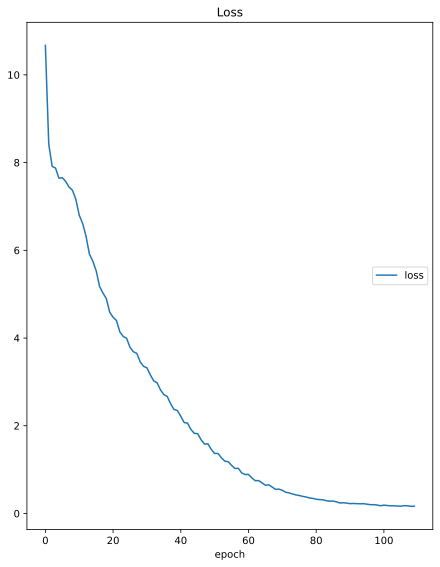

Loss
	loss             	 (min:    0.162, max:   10.672, cur:    0.166)


In [ ]:
plotlosses = PlotLosses()

MAX_STEPS = 3500
LOG_EVERY = 32
losses = []
VOCAB_SIZE = 25670

# Boucle d'entraînement
for step in range(MAX_STEPS):
    batch = next(train_dataset)
    params, optimizer_state, loss = train_step(
        params, optimizer_state, batch, llm.apply, optimizer.update)
    losses.append(loss)
    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []


### 3. Inspecter le LLM entraîné <font color='orange'>Débutant</font>


**Rappel :** n'oubliez pas d'exécuter tout le code présenté jusqu'à présent dans cette section avant de lancer les cellules ci-dessous !

Générons maintenant un peu de texte et voyons comment notre modèle a performé. NE STOPPEZ PAS LA CELLULE UNE FOIS QU'ELLE EST EN COURS D'EXÉCUTION, CELA FERA PLANTER LA SESSION.


In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(2, ))
def generate_prediction(params, input, apply_fn):
  logits = apply_fn(params, input)
  argmax_out = jnp.argmax(logits, axis=-1)
  return argmax_out[0][-1].astype(int)

def generate_random_shakespeare(llm, params, id_2_word, word_2_id):
    '''
    Get the model output
    '''

    prompt = "life"
    print(prompt, end="")
    tokens = prompt.split()

    # predict and append
    for i in range(15):
      input = jnp.array([[word_2_id[t] for t in tokens]]).astype(int)
      prediction = generate_prediction(params, input, llm.apply)
      prediction = id_2_word[int(prediction)]
      tokens.append(prediction)
      print(" "+prediction, end="")

    return " ".join(tokens)

id_2_word = train_dataset.id_to_word
word_2_id = train_dataset.word_to_id

generated_shakespeare = generate_random_shakespeare(llm, params, id_2_word, word_2_id)

life an hour Hath been a lamb indeed, that baes like a bear. MENENIUS: He's a

Enfin, nous avons implémenté tout ce qui précède en prenant l'ID de jeton avec la probabilité maximale d'être correct. C'est ce qu'on appelle le décodage gourmand, car nous avons uniquement pris le jeton le plus probable. Cela a bien fonctionné dans ce cas, mais il y a des situations où cette approche gourmande peut dégrader les performances, notamment lorsque nous souhaitons générer un texte réaliste.

Il existe d'autres méthodes pour échantillonner à partir du décodeur, avec un algorithme célèbre étant la recherche par faisceau (beam search). Nous fournissons ci-dessous des ressources pour ceux qui souhaitent en savoir plus à ce sujet.

[Décodage Gourmand](https://www.youtube.com/watch?v=DW5C3eqAFQM&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=4)

[Recherche par Faisceau](https://www.youtube.com/watch?v=uG3xoYNo3HM&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=5)


## **Conclusion**

**Résumé :**

Vous avez maintenant maîtrisé l'essentiel du fonctionnement d'un Large Language Model (LLM) ! Ces outils puissants ont le potentiel de transformer un large éventail de tâches. Cependant, comme tout modèle de deep learning, leur efficacité réside dans leur application aux bons problèmes avec les bonnes données.

Prêt à passer au niveau supérieur ? Plongez dans le fine-tuning de vos propres LLMs et libérez encore plus de potentiel ! Je vous recommande vivement d'explorer le tutoriel de l'année dernière sur les méthodes de fine-tuning efficaces pour obtenir une vue d'ensemble des techniques avancées. Le voyage ne s'arrête pas là—il y a encore tant à découvrir ! [LLMs pour Tous 2023](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/large_language_models.ipynb)

Le monde des LLMs est à vous—allez créer quelque chose d'incroyable ! 🌟🚀

**Prochaines étapes :**

[**Fine-tuning Efficace des LLMs avec Hugging Face**](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/large_language_models.ipynb)

**Références :** pour des références supplémentaires, consultez les liens mentionnés dans les sections spécifiques de ce colab.

* [Article "Attention is all you need"](https://arxiv.org/abs/1706.03762)
* [Vidéos supplémentaires sur les transformers](https://www.youtube.com/playlist?list=PLmZlBIcArwhOPR2s-FIR7WoqNaBML233s)
* [Article LoRA](https://arxiv.org/abs/2106.09685)
* [RLHF](https://huggingface.co/blog/rlhf) (comment ChatGPT a été entraîné)
* [Extension de la longueur du contexte](https://kaiokendev.github.io/context)